# Simulating optical auto correlation of a cut-off pulsed laser (with chirp)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants
from scipy import integrate
from scipy import fftpack
from scipy import signal
from scipy import interpolate
from scipy import optimize
import pickle

from chirp_diagnostic_functions import *

from IPython.core.debugger import set_trace
from datetime import datetime

Electric field of a laser $E(t)$ with a chirp is relative to the form:

$$E(t) \sim f^{1/2}(t) \cdot \exp\left(-i \omega t - i \phi(t)\right)$$

with the central frequency $w$ and the linear chirp $\phi(t)$:

$$\phi_{gauss}(t) = \frac{a_{gauss} t^2}{2}$$

- for an gaussian pulse $f_{gauss}(t)$ is:
$$f_{gauss}(t) = \left(\frac{A_{gauss}}{\sqrt{2 \cdot \pi \cdot \tau_0 \cdot \tau}} \exp\left(-\frac{t^2}{2 \cdot \tau^2}\right)\right)^2$$

 - with the normalization constant $A_{gauss}$, the pulse duration $\tau_0$, the central frequency $w$ and the chirp coefficient $\alpha$.

 - where $\tau = \sqrt{\alpha^2 / \tau_0^2 + \tau_0^2}$ characterizes the chirped pulse length and $a = \alpha/(\alpha^2+\tau_0^4)$ is the frequency chirp rate.

- for an secant pulse $f_{secant}(t)$ is:
$$f_{secant}(t) = A_{secant} * sech^2\left(\frac{t}{\tau_0}\right) = A_{secant} * \left(\frac{2}{exp(\frac{t}{\tau_0}) + exp(-\frac{t}{\tau_0})}\right)^2$$

 - with the linear chirp:
$$\phi_{secant}(t) = \alpha_{secant}\left(\frac{t}{\tau_0}\right)^2$$


see: 
- Glässl, M., Barth, A. M., Gawarecki, K., MacHnikowski, P., Croitoru, M. D., Lüker, S., … Axt, V. M. (2013). Biexciton state preparation in a quantum dot via adiabatic rapid passage: Comparison between two control protocols and impact of phonon-induced dephasing. Physical Review B - Condensed Matter and Materials Physics, 87(8), 1–8. http://doi.org/10.1103/PhysRevB.87.085303
- Hirayama, T., & Sheik-Bahae, M. (2002). Real-time chirp diagnostic for ultrashort laser pulses. Optics Letters, 27(10), 860. http://doi.org/10.1364/OL.27.000860).



MaiTai Laser | values
-----------|--------------
repitition rate| 80 MHz
center wavelength (tunable) $\lambda_0$| 700 nm to 1000 nm
power | 3.2 Watt
pulse duration $\tau_0$ | 100 fs - 20 ps

We start with the pulse duration $\tau_0$ in (ps) and choose the central wavelength $\lambda$ in (pm).

In [3]:
tau_0_laser = 0.1
lambda_laser = 785e3

frequency_laser = constants.c / lambda_laser
omega_laser = 2 * np.pi * frequency_laser

We calculate E for different $\alpha$ in (ps)$^2$ for gauss and unitless for secant.

In [4]:
alpha_gauss_values = np.array((0.0, 0.02))
alpha_secant_values = np.array((0.0, 0.3))

Calculate $A$-arrays so that $\int f(t) dt = 1$

In [5]:
A_gauss = normalize_f(f_gauss, tau_0_laser, omega_laser)
A_secant = normalize_f(f_secant, tau_0_laser, omega_laser)

Set t_limit

In [6]:
t_limit = 30 * tau_0_laser
t_values_1 = np.linspace(-t_limit, t_limit, 12000)

In [7]:
E_gauss_values_1 = np.empty((t_values_1.size, alpha_gauss_values.size), dtype=complex)
for i in range(alpha_gauss_values.size):
    E_gauss_values_1[:,i] = E_gauss(t_values_1, A_gauss, tau_0_laser,
                                    omega_laser, alpha_gauss_values[i])
    
E_secant_values_1 = np.empty((t_values_1.size, alpha_secant_values.size), dtype=complex)
for i in range(alpha_secant_values.size):
    E_secant_values_1[:,i] = E_secant(t_values_1, A_secant, tau_0_laser,
                                    omega_laser, alpha_secant_values[i])

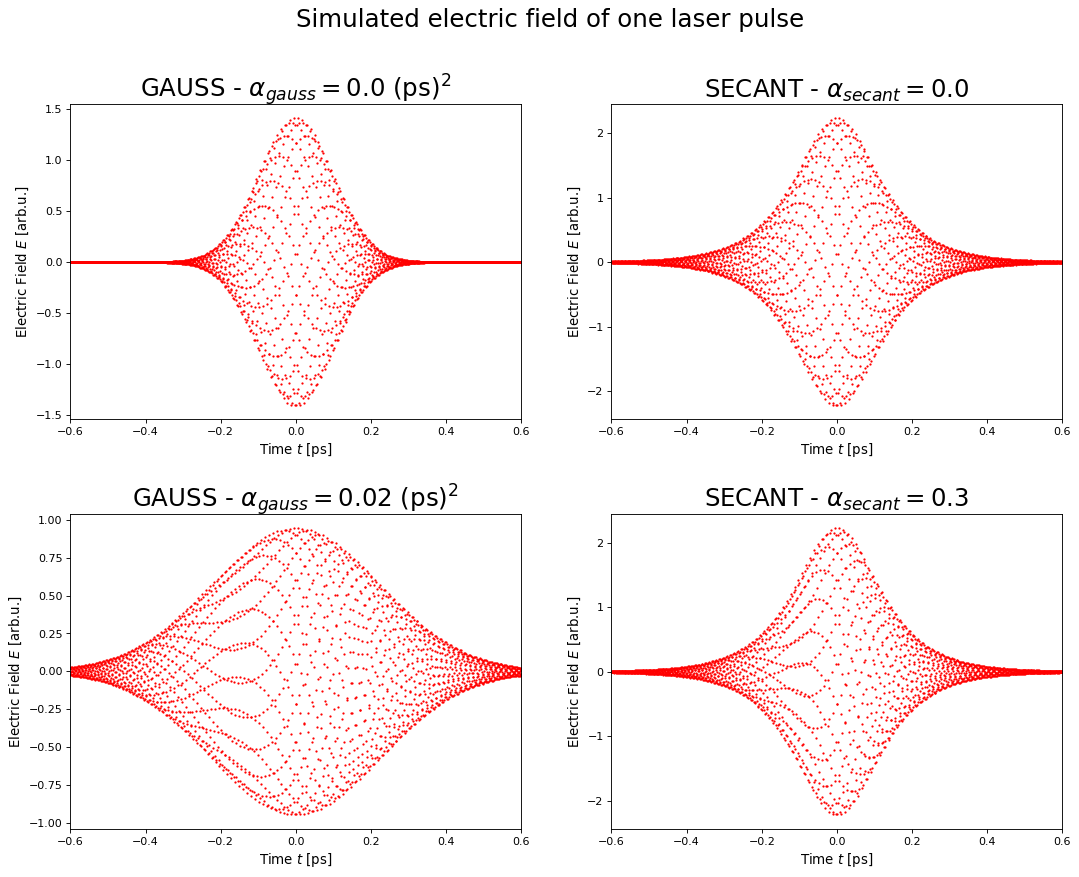

In [33]:
plt.figure(figsize=(16, max(alpha_gauss_values.size, alpha_secant_values.size) * 6), dpi=80)
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('Simulated electric field of one laser pulse', fontsize = 22)

for i in range(alpha_gauss_values.size):
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 1)
    plt.title(r"GAUSS - $\alpha_{gauss}" + " = {}$ (ps)$^2$".format(alpha_gauss_values[i]), fontsize=22)
    plt.xlabel(r"Time $t$ [ps]", fontsize = 12)
    plt.ylabel(r"Electric Field $E$ [arb.u.]", fontsize = 12)
    plt.xlim(- tau_0_laser * 6, tau_0_laser * 6)
    plt.plot(t_values_1, np.real(E_gauss_values_1[:,i]), "r.", markersize=2)

for i in range(alpha_secant_values.size):
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 2)
    plt.title(r"SECANT - $\alpha_{secant}" + " = {}$".format(alpha_secant_values[i]), fontsize=22)
    plt.xlabel(r"Time $t$ [ps]", fontsize = 12)
    plt.ylabel(r"Electric Field $E$ [arb.u.]", fontsize = 12)
    plt.xlim(- tau_0_laser * 6, tau_0_laser * 6)
    plt.plot(t_values_1, np.real(E_secant_values_1[:,i]), "r.", markersize=2)

plt.show()

## FFT
Transform interpolated signal into frequency-space per FFT.

In [31]:
sample_freq_gauss = np.empty(t_values_1.size)
signal_gauss_fft = np.empty((t_values_1.size, alpha_gauss_values.size), dtype=complex)
for i in range(alpha_gauss_values.size):
    # The FFT of the signal
    signal_gauss_fft[:, i] = fftpack.fft(np.real(E_gauss_values_1[:,i]))

sample_freq_secant = np.empty(t_values_1.size)
signal_secant_fft = np.empty((t_values_1.size, alpha_secant_values.size), dtype=complex)
for i in range(alpha_secant_values.size):
    # The FFT of the signal
    signal_secant_fft[:, i] = fftpack.fft(np.real(E_secant_values_1[:,i]))

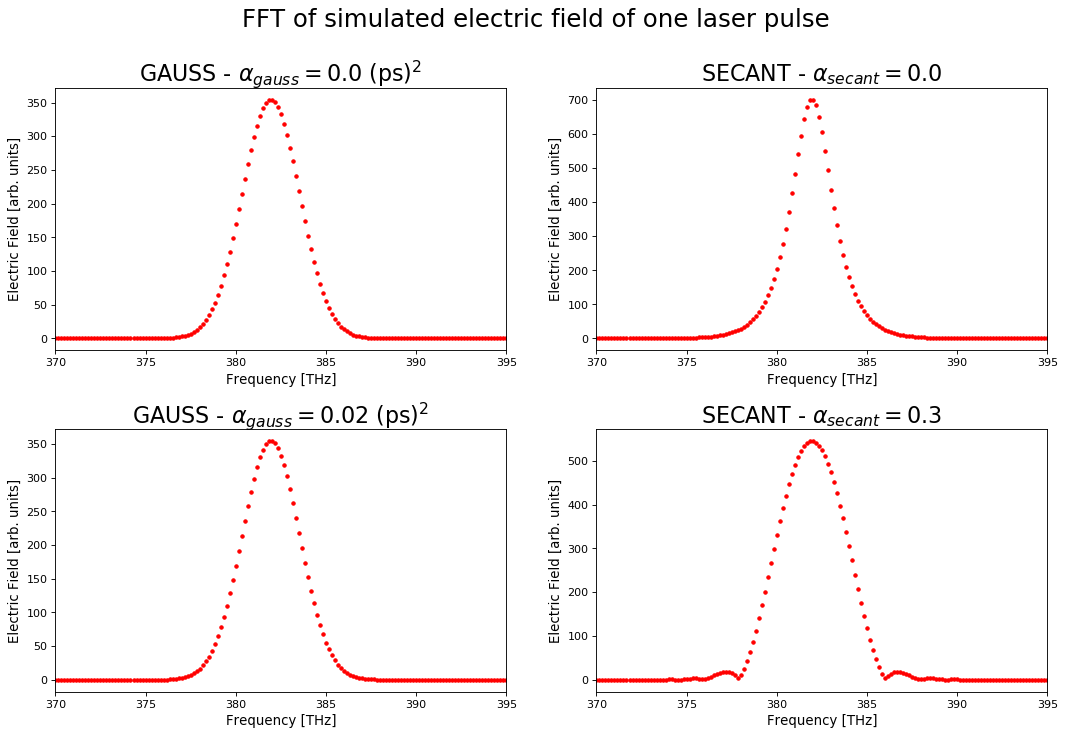

In [47]:
# Plot the FFT power
plt.figure(figsize=(16, max(alpha_gauss_values.size, alpha_secant_values.size) * 5), dpi=80)
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('FFT of simulated electric field of one laser pulse', fontsize = 22)
for i in range(alpha_gauss_values.size):    
    # And the power (sig_fft is of complex dtype)
    data_gauss_power = np.abs(signal_gauss_fft[:, i])
    # The corresponding frequencies
    sample_freq_gauss = fftpack.fftfreq(E_gauss_values_1[:,i].size,
                                        d = t_limit * 2 / t_values_1.size)
    
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 1)
    plt.title(r"GAUSS - $\alpha_{gauss}" + " = {}$ (ps)$^2$".format(alpha_gauss_values[i]), fontsize=20)
    plt.xlabel('Frequency [THz]', fontsize = 12)
    plt.ylabel('Electric Field [arb. units]', fontsize = 12)
    plt.xlim(370, 395)    
    plt.plot(sample_freq_gauss, data_gauss_power, "r.")
    
for i in range(alpha_secant_values.size):    
    # And the power (sig_fft is of complex dtype)
    data_secant_power = np.abs(signal_secant_fft[:, i])
    # The corresponding frequencies
    sample_freq_secant = fftpack.fftfreq(E_secant_values_1[:,i].size,
                                        d = t_limit * 2 / t_values_1.size)
    
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 2)
    plt.title(r"SECANT - $\alpha_{secant}" + " = {}$".format(alpha_secant_values[i]), fontsize=20)
    plt.xlabel('Frequency [THz]', fontsize = 12)
    plt.ylabel('Electric Field [arb. units]', fontsize = 12)
    plt.xlim(370, 395)    
    plt.plot(sample_freq_secant, data_secant_power, "r.")

plt.show()

## Implement Filter to simulate cut-off of the slit

Set cut-off range in (THz):

In [18]:
cut_off_range = 4

In [19]:
signal_gauss_filtered_fft = signal_gauss_fft.copy()
for j in range(alpha_gauss_values.size):
    for i in range(data_gauss_power.size):
        if abs(sample_freq_gauss[i]) < frequency_laser - cut_off_range / 2:
            signal_gauss_filtered_fft[i, j] = 0
        if abs(sample_freq_gauss[i]) > frequency_laser + cut_off_range / 2:
            signal_gauss_filtered_fft[i, j] = 0

signal_secant_filtered_fft = signal_secant_fft.copy()
for j in range(alpha_secant_values.size):
    for i in range(data_secant_power.size):
        if abs(sample_freq_secant[i]) < frequency_laser - cut_off_range / 2:
            signal_secant_filtered_fft[i, j] = 0
        if abs(sample_freq_secant[i]) > frequency_laser + cut_off_range / 2:
            signal_secant_filtered_fft[i, j] = 0

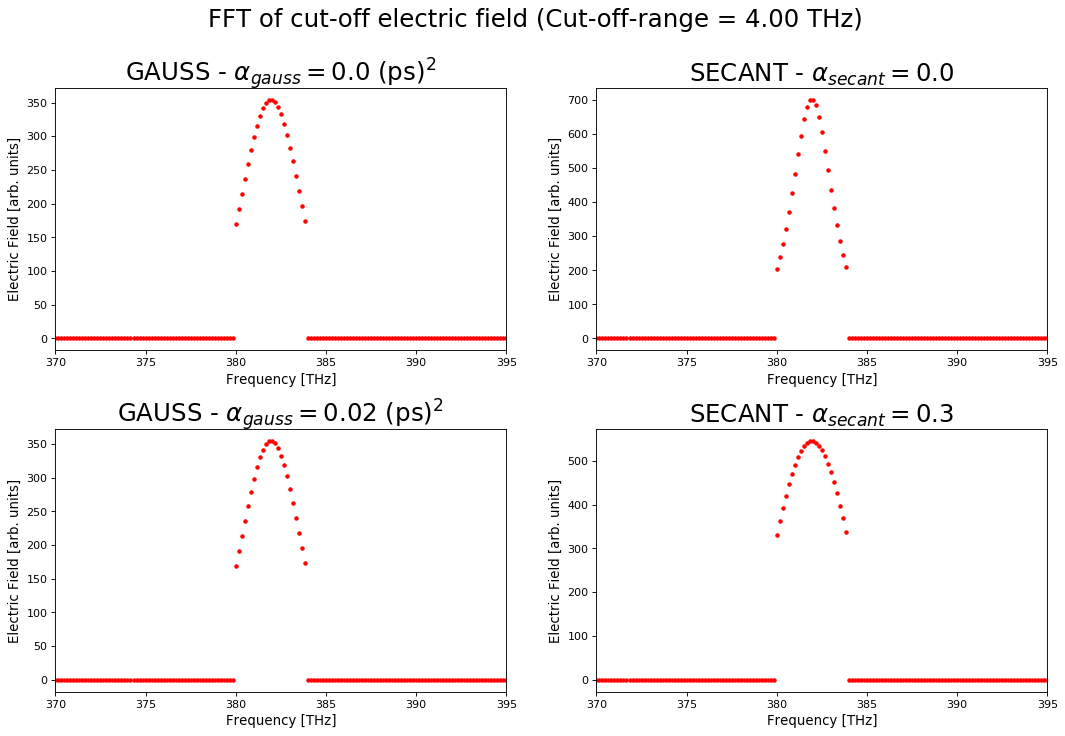

In [48]:
plt.figure(figsize=(16, max(alpha_gauss_values.size, alpha_secant_values.size) * 5), dpi=80)
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('FFT of cut-off electric field (Cut-off-range = %.02f THz)' % cut_off_range, fontsize = 22)
for i in range(alpha_gauss_values.size):
    data_power = np.abs(signal_gauss_filtered_fft[:, i])    
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 1)
    plt.title(r"GAUSS - $\alpha_{gauss}" + " = {}$ (ps)$^2$".format(alpha_gauss_values[i]), fontsize=22)
    plt.xlabel('Frequency [THz]', fontsize = 12)
    plt.ylabel('Electric Field [arb. units]', fontsize = 12)
    plt.xlim(370, 395)
    plt.plot(sample_freq_gauss, data_power, "r.")

for i in range(alpha_secant_values.size):
    data_power = np.abs(signal_secant_filtered_fft[:, i])    
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 2)
    plt.title(r"SECANT - $\alpha_{secant}" + " = {}$".format(alpha_secant_values[i]), fontsize=22)
    plt.xlabel('Frequency [THz]', fontsize = 12)
    plt.ylabel('Electric Field [arb. units]', fontsize = 12)
    plt.xlim(370, 395)
    plt.plot(sample_freq_secant, data_power, "r.")
    
plt.show()

## Inverse FFT
Transform filtered signal back into time-space per inverse FFT.

In [21]:
E_gauss_cut_off_values_1 = np.empty((t_values_1.size, alpha_gauss_values.size))
for i in range(alpha_gauss_values.size):
    E_gauss_cut_off_values_1[:,i] = np.real(
        fftpack.ifft(signal_gauss_filtered_fft[:, i]))
    
E_secant_cut_off_values_1 = np.empty((t_values_1.size, alpha_secant_values.size))
for i in range(alpha_secant_values.size):
    E_secant_cut_off_values_1[:,i] = np.real(
        fftpack.ifft(signal_secant_filtered_fft[:, i]))

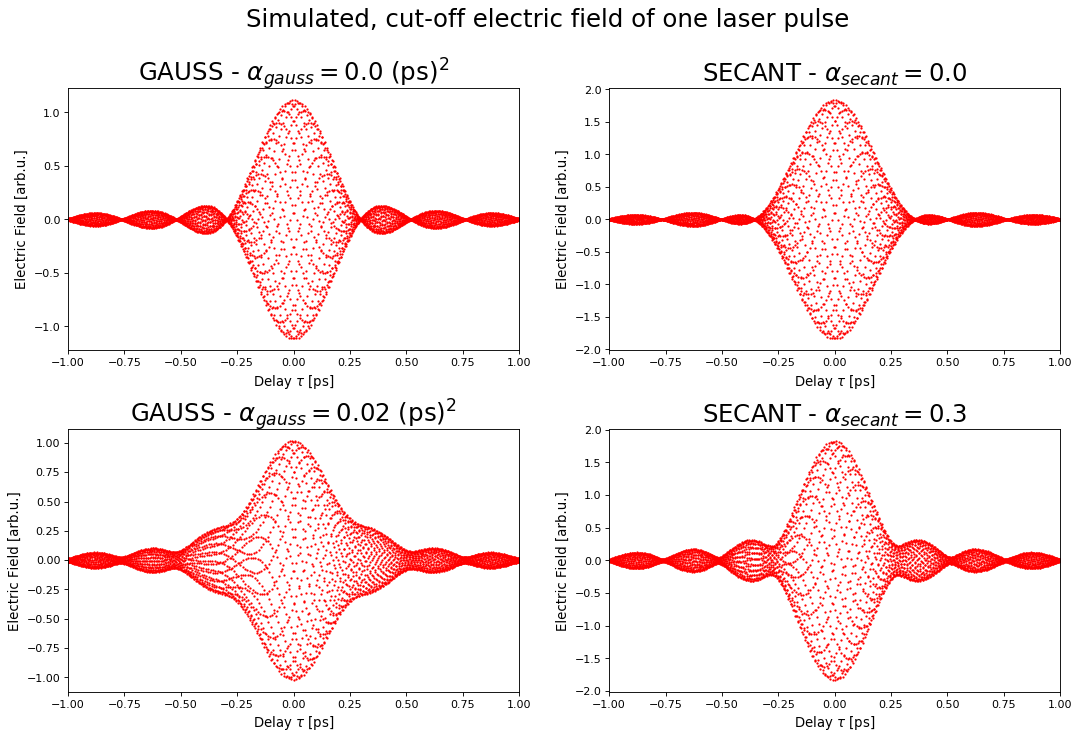

In [45]:
plt.figure(figsize=(16, max(alpha_gauss_values.size, alpha_secant_values.size) * 5), dpi=80)
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('Simulated, cut-off electric field of one laser pulse', fontsize = 22)
for i in range(alpha_gauss_values.size):
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 1)
    plt.title(r"GAUSS - $\alpha_{gauss}" + " = {}$ (ps)$^2$".format(alpha_gauss_values[i]), fontsize=22)
    plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
    plt.ylabel(r"Electric Field [arb.u.]", fontsize = 12)
    plt.xlim(-1, 1)
    plt.plot(t_values_1, E_gauss_cut_off_values_1[:,i], "r.", markersize=2) 

for i in range(alpha_secant_values.size):
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 2)
    plt.title(r"SECANT - $\alpha_{secant}" + " = {}$".format(alpha_secant_values[i]), fontsize=22)
    plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
    plt.ylabel(r"Electric Field [arb.u.]", fontsize = 12)
    plt.xlim(-1, 1)
    plt.plot(t_values_1, E_secant_cut_off_values_1[:,i], "r.", markersize=2) 
    
plt.show()

# CHANGE INTEGRATION TO FUNCTION WITH FIXED SAMPLES
(https://docs.scipy.org/doc/scipy/reference/integrate.html#integrating-functions-given-fixed-samples)

# Interferometric autocorrelation

![Setup for an interferometric autocorrelator](https://upload.wikimedia.org/wikipedia/en/d/dd/Optical-interferometric-autocorrelation-setup.png)

Setup for an interferometric autocorrelator, similar to the field autocorrelator above, with the following optics added:
- **L**: converging lens,
- **SHG**: second-harmonic generation crystal,
- **F**: spectral filter to block the fundamental wavelength.

(see https://en.wikipedia.org/wiki/Optical_autocorrelation)

The intensity recorded by the detecter is:

$$ I_M(\tau) = \int_{-\infty}^{+\infty}|(E_{cut-off}(t)+E_{cut-off}(t-\tau))^2|^2dt $$

later on we normalize the value so it will become 1 for very big or small $\tau$

But before that we need to calculate $E_{cut-off}(t)$.

$$\hat{E}_{cut-off}(f) = \hat{E(f)} \cdot \hat{c}(f)$$

$$E_{cut-off}(t) = E(t) * c(t)$$

with $*$ denoting convolution and $\hat{c}(f)$ denoting the cut off in the frequency realm.

$$\hat{c}(f) = \mathrm{rect}\left(\frac{f - \textrm{frequency_laser}}{\textrm{cut_off_range}}\right)$$

In [23]:
def I_M(E, tau_values, A, tau_0, omega, alpha):
    I_M_values = np.array(())
    for tau in tau_values:
        func = lambda t: np.abs((E(t, A, tau_0, omega, alpha)
                                 + E(t - tau, A, tau_0, omega, alpha))**2)**2
        # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
        I_M_values = np.append(I_M_values,
                               integrate.quad(func, - np.inf, np.inf)[0]) 
    # normalize result 
    return I_M_values / np.mean(I_M_values[0:30])

Number of $\tau$-values to calculate:

In [24]:
tau_limit = tau_0_laser * 4

Calculate the number of values so we can fft to at least $3 \cdot \omega$ 

$$3 \cdot \frac{\omega_{laser}}{2\pi} < f_{nyq} = \frac{f_{sampling}}{2} = \frac{\frac{\textit{number_tau_values}}{\textit{tau_limit} \cdot 2}}{2} $$

$$\Rightarrow \textit{number_tau_values} = \frac{6}{\pi} \cdot \textit{tau_limit} \cdot \omega_{laser} $$

"//100 * 100 + 100" so we don't get an integer multiple (which brings weird results)

In [25]:
number_tau_values = int((6 / np.pi * tau_limit * omega_laser)//100 * 100 + 100)

In [26]:
def gen_I_M_values(E, tau_limit, number_tau_values, alpha_values,  A, tau_0, omega):
    tau_values = np.linspace(-tau_limit, tau_limit, number_tau_values)
    I_M_values = np.empty((tau_values.size, alpha_values.size))    
    for i in range(alpha_values.size):
        I_M_values[:,i] = I_M(E, tau_values, A, tau_0, omega, alpha_values[i])
    return tau_values, I_M_values

In [27]:
while(True):
    answer_1 = input('Should data be loaded from file (l) or generated (g)?: ')
    if answer_1 == "l":
        path = r"../../Data/Autocorrelator/Simulation/" + \
        r"Autocorrelation_Simulation_Gauss_2018-10-01 15_52_55.595168.txt"        
        data = np.loadtxt(path)
        if data[0, 0] == 0:
            laser_type = "gauss"
        elif data[0, 0] == 1:
            laser_type = "secant"
        alpha_values = data[0, 1:]
        tau_values_1 = data[1:, 0]
        I_M_values_1 = data[1:, 1:]
        break
    if answer_1 == "g":
        while(True):
            answer_2 = input('Should we generate and save for gauss (g) or secant (s) pulse?: ')   
            if answer_2 == "g":
                alpha_values = alpha_gauss_values
                A = A_gauss
                laser_type = "gauss"
                tau_values_1, I_M_values_1 = gen_I_M_values(E_gauss, tau_limit, number_tau_values,
                                                                      alpha_values,  A,
                                                                      tau_0_laser, omega_laser)        
                path = r"../../Data/Autocorrelator/Simulation/"
                data = np.empty((tau_values_1.size + 1, alpha_values.size + 1))
                data[0] = np.append(0, alpha_values)
                data[1:] = np.append(tau_values_1[:, np.newaxis], I_M_values_1, axis=1)
                np.savetxt(path + "Autocorrelation_Simulation_Gauss_"
                           + str(datetime.now()).replace(":", "_") 
                           + ".txt", data,
                           header = "tau_values | I", comments=" first line corresponds to (0=Gauss or 1=Secant) and then alpha_values")
                break
            if answer_2 == "s":
                alpha_values = alpha_secant_values
                A = A_secant
                laser_type = "secant"
                tau_values_1, I_M_values_1 = gen_I_M_values(E_secant, tau_limit, number_tau_values,
                                                                      alpha_values,  A,
                                                                      tau_0_laser, omega_laser)        
                path = r"../../Data/Autocorrelator/Simulation/"
                data = np.empty((tau_values_1.size + 1, alpha_values.size + 1))
                data[0] = np.append(1, alpha_values)
                data[1:] = np.append(tau_values_1[:, np.newaxis], I_M_values_1, axis=1)
                np.savetxt(path + "Autocorrelation_Simulation_Secant_"
                           + str(datetime.now()).replace(":", "_") 
                           + ".txt", data,
                           header = "tau_values | I", comments=" first line corresponds to (0=Gauss or 1=Secant) and then alpha_values")
                break
        break

Should data be loaded from file (l) or generated (g)?:  g
Should we generate and save for gauss (g) or secant (s) pulse?:  s


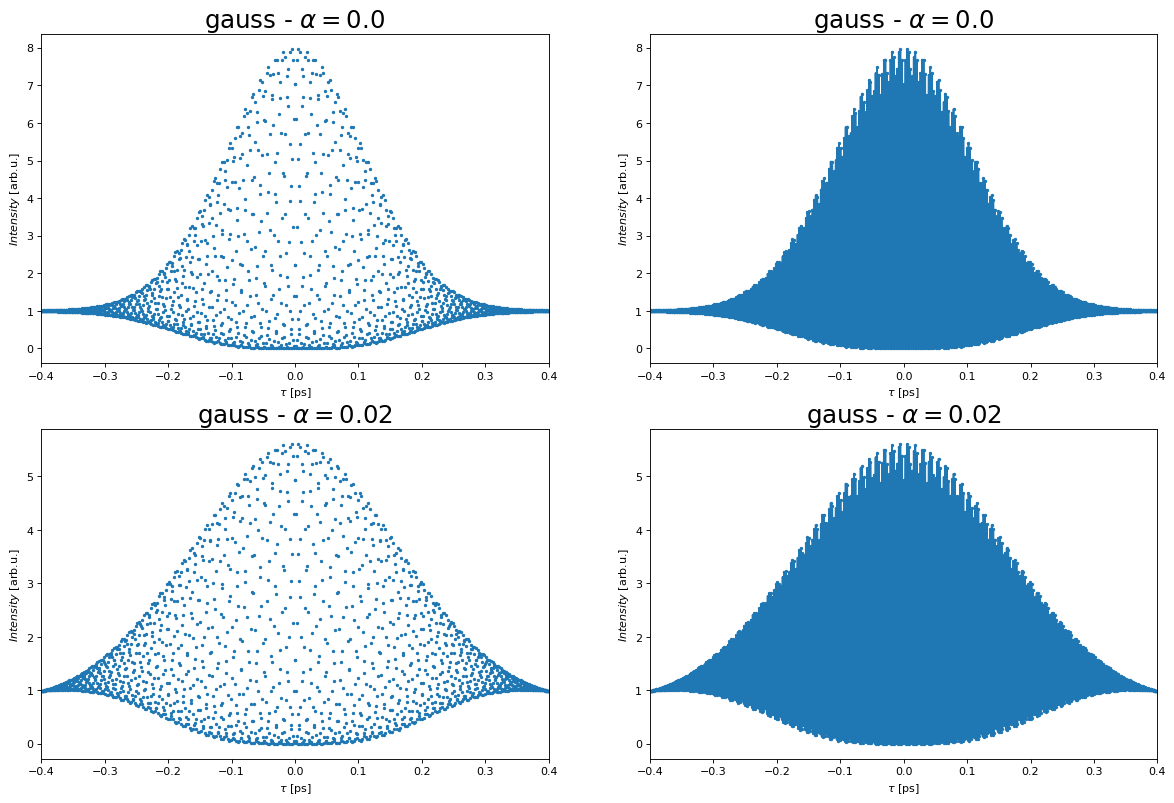

In [23]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, alpha_values.size * 6), dpi=80)

for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_values_1[:,i], ".", markersize=4)
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_values_1[:,i], ".", ls="-", markersize=4)   

plt.show()

## FFT
Transform interpolated signal into frequency-space per FFT.

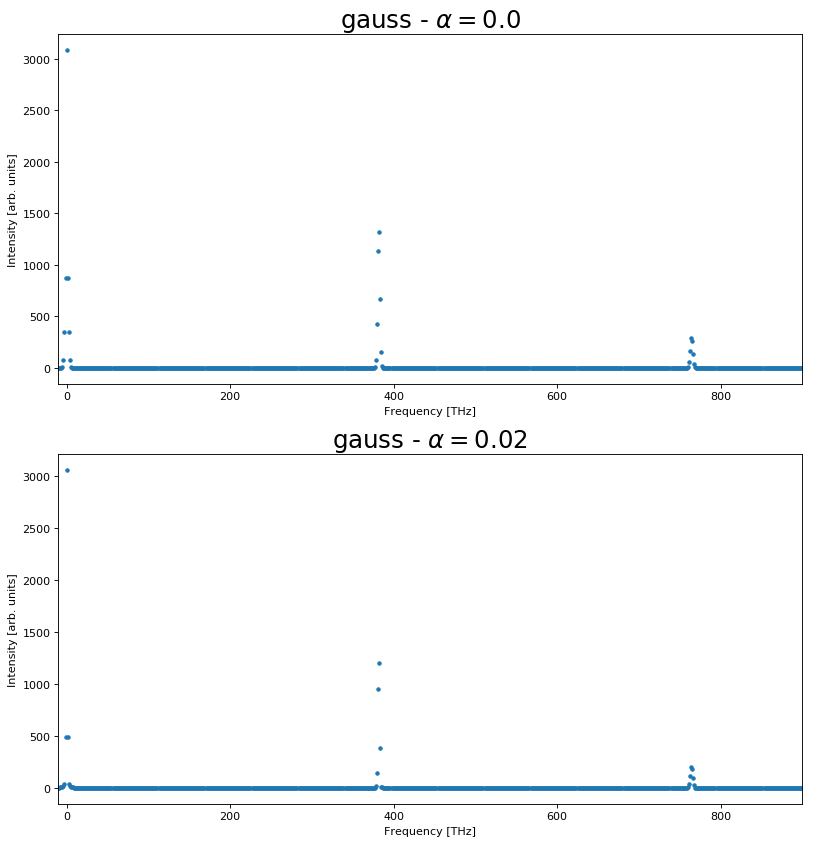

In [24]:
# Plot the FFT power
plt.figure(figsize=(12, alpha_values.size * 3.5), dpi=80)
plt.subplots_adjust(top = 1.5)

sample_freq_gauss = np.empty(tau_values_1.size)
I_M_fft = np.empty((tau_values_1.size, alpha_values.size), dtype=complex)

for i in range(alpha_values.size):
    # The FFT of the signal
    I_M_fft[:, i] = fftpack.fft(I_M_values_1[:,i])
    # And the power (sig_fft is of complex dtype)
    data_power = np.abs(I_M_fft[:, i])
    # The corresponding frequencies
    sample_freq_gauss = fftpack.fftfreq(I_M_values_1[:,i].size,
                                        d = tau_limit * 2 / tau_values_1.size)
    
    plt.subplot(alpha_values.size, 1, i + 1)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel('Frequency [THz]')
    plt.ylabel('Intensity [arb. units]')
    plt.xlim(-10, 900)    
    plt.plot(sample_freq_gauss, data_power, ".")

plt.show()

## Implement filter
Citation from MOSAIC paper:
"The bandpass filter functions were taken as rectangular functions centered at $\omega$
and $2\omega$ having bandwidths of $\omega$.

Alternative with "correct" filter implementations:

Scipy Signal Filter Tutorial (https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html)

How many taps? (https://dsp.stackexchange.com/a/31210)

In [25]:
I_M_filtered_fft = I_M_fft.copy()

for j in range(alpha_values.size):
    for i in range(data_power.size):
        if frequency_laser * 0.5 < abs(sample_freq_gauss[i]) < frequency_laser * 1.5:
            I_M_filtered_fft[i, j] = 0
        if frequency_laser * 1.5 < abs(sample_freq_gauss[i]) < frequency_laser * 2.5:
            I_M_filtered_fft[i, j] = I_M_filtered_fft[i, j] * 2

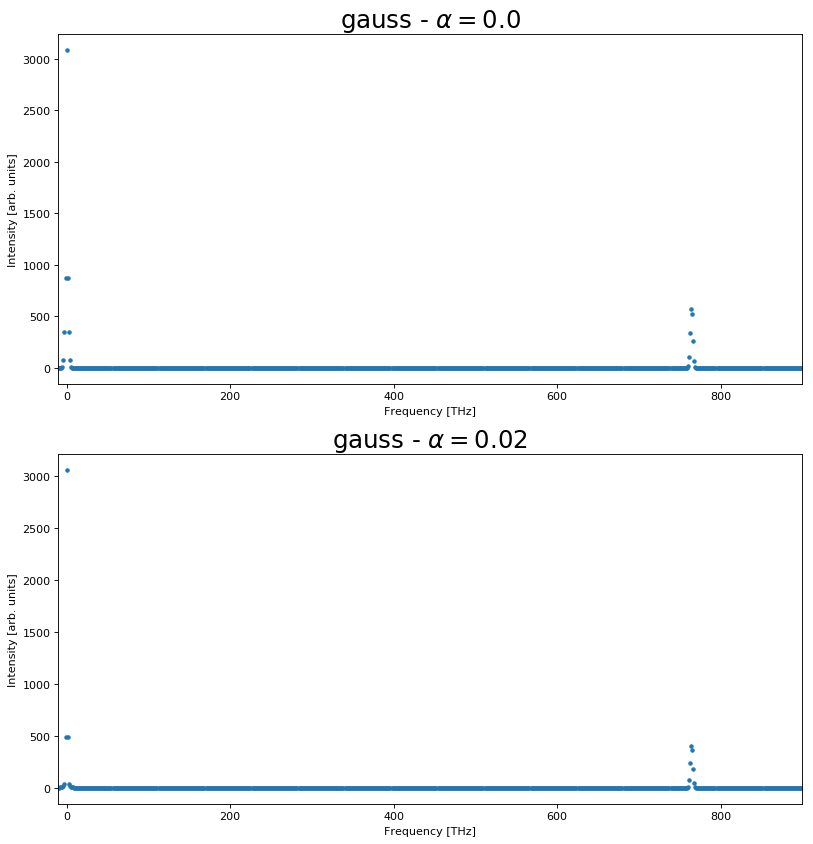

In [26]:
# Plot the FFT power
plt.figure(figsize=(12, alpha_values.size * 3.5), dpi=80)
plt.subplots_adjust(top = 1.5)

for i in range(alpha_values.size):
    data_power = np.abs(I_M_filtered_fft[:, i])
    
    plt.subplot(alpha_values.size, 1, i + 1)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel('Frequency [THz]')
    plt.ylabel('Intensity [arb. units]')
    plt.xlim(-10, 900)
    plt.plot(sample_freq_gauss, data_power, ".")

plt.show()

## Inverse FFT
Transform filtered signal back into time-space per inverse FFT.

In [27]:
I_M_filtered_values = np.empty((tau_values_1.size, alpha_values.size))
for i in range(alpha_values.size):
    I_M_filtered_values[:,i] = np.real(
        fftpack.ifft(I_M_filtered_fft[:, i]))

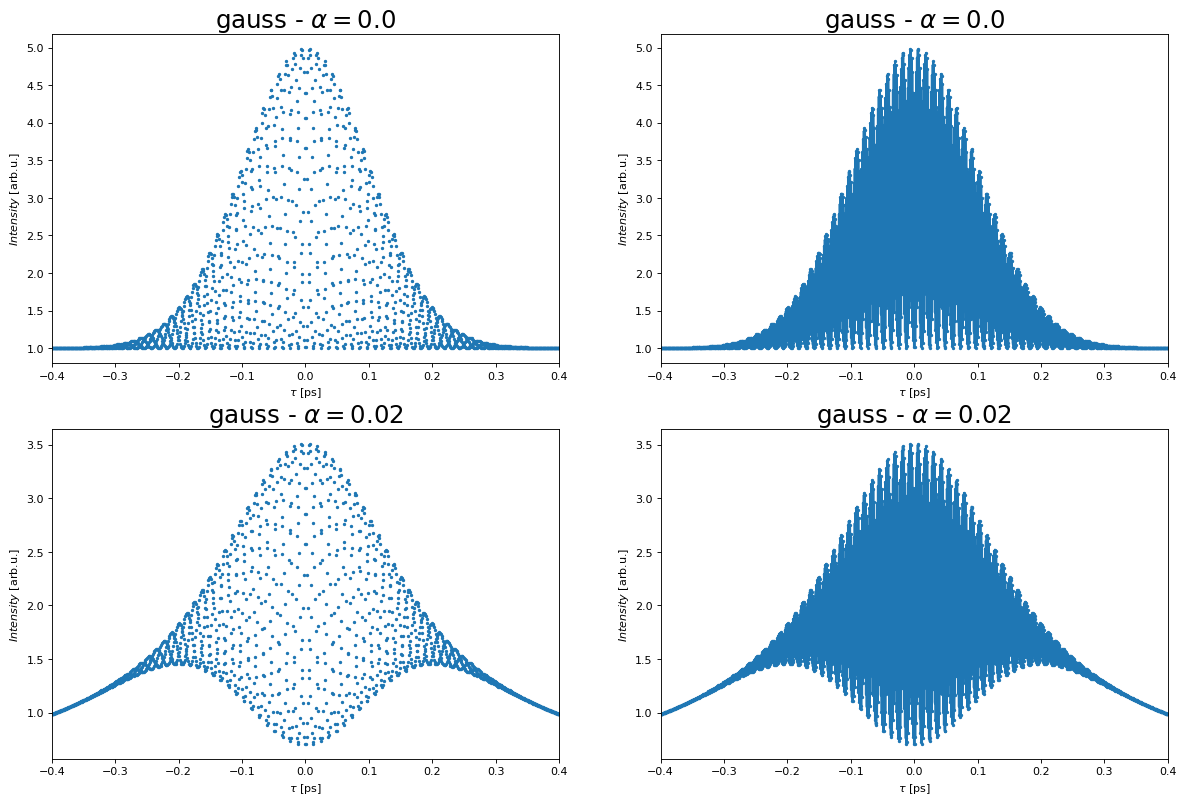

In [28]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, alpha_values.size * 6), dpi=80)

for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_filtered_values[:,i], ".", markersize=4)
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_filtered_values[:,i], ".", ls="-", markersize=4)  

plt.show()